<a href="https://colab.research.google.com/github/LukichevaPolina/nlp_lab/blob/main/nlp_lab_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from string import punctuation
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from copy import deepcopy
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

Dataset description: https://www.kaggle.com/datasets/suchintikasarkar/sentiment-analysis-for-mental-health/data

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/nlp_lab/Combined Data.csv")
data = data.drop("Unnamed: 0", axis=1)
data.head()

,statement,status
0,oh my gosh,Anxiety
1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,I've shifted my focus to something else but I'...,Anxiety
4,"I'm restless and restless, it's been a month n...",Anxiety


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53043 entries, 0 to 53042
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   statement  52681 non-null  object
 1   status     53043 non-null  object
dtypes: object(2)
memory usage: 828.9+ KB


# EDA


In [ ]:
data.isna().sum()

,0
statement,362
status,0


Очень мальнькая часть данных пропущена, можем просто избавиться от этих строчек.

In [ ]:
data = data.dropna()

<Axes: title={'center': 'Class distribution'}, xlabel='status'>

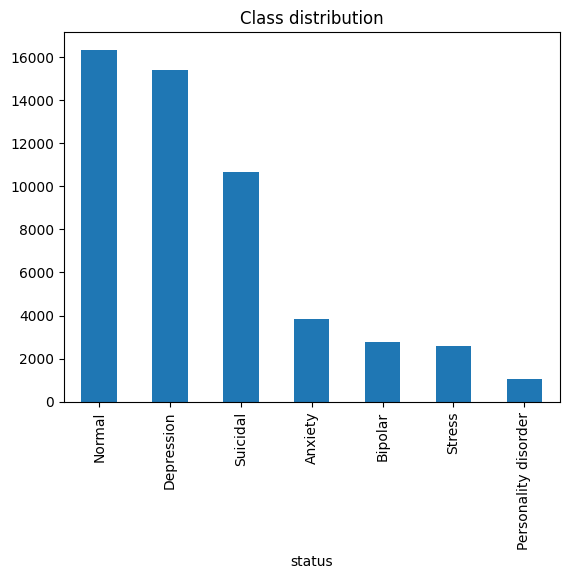

In [ ]:
data["status"].value_counts().plot.bar(title='Class distribution')

По графику видно, что данные достаточно несбаласированные - классы "Normal", "Depression", "Suicidal" представленны в гораздо большем объеме по сравнению с остальными. Что с этим делать? Пока вопрос... (первым делом попробую class weights).

In [ ]:
def class_features_distribution(data, plot_title, function):
    classes = data["status"].unique()
    fig, ax = plt.subplots(nrows=2, ncols=4, sharex=False, sharey=True, figsize=(15, 7))
    fig.suptitle(plot_title)

    for i, class_name in enumerate(classes):
        subdata = data[data["status"] == class_name]
        feature = subdata["statement"].apply(function).plot.hist(bins=25, alpha=0.5, color='g', ax=ax[i // 4, i % 4])
        ax[i // 4, i % 4].title.set_text(f"{class_name}", )

Графики распределения длины текстов в классах


---



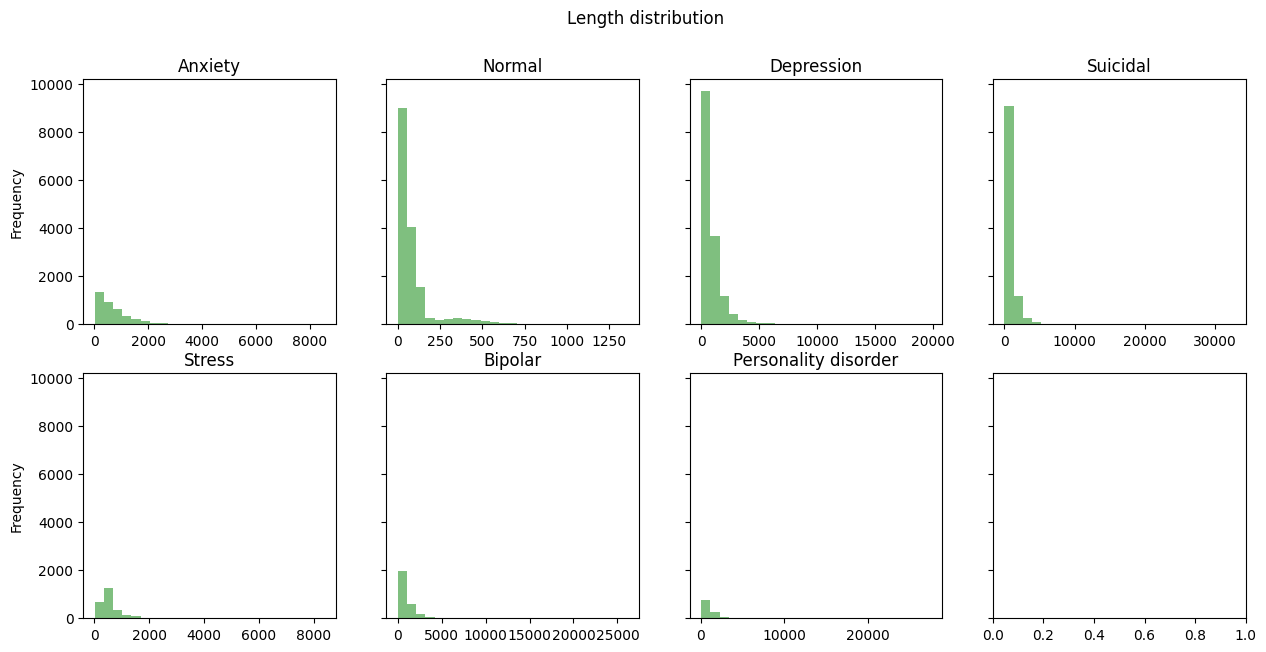

In [ ]:
class_features_distribution(data, "Length distribution", lambda x: len(x))

Графики распределения знаков препинания в классах

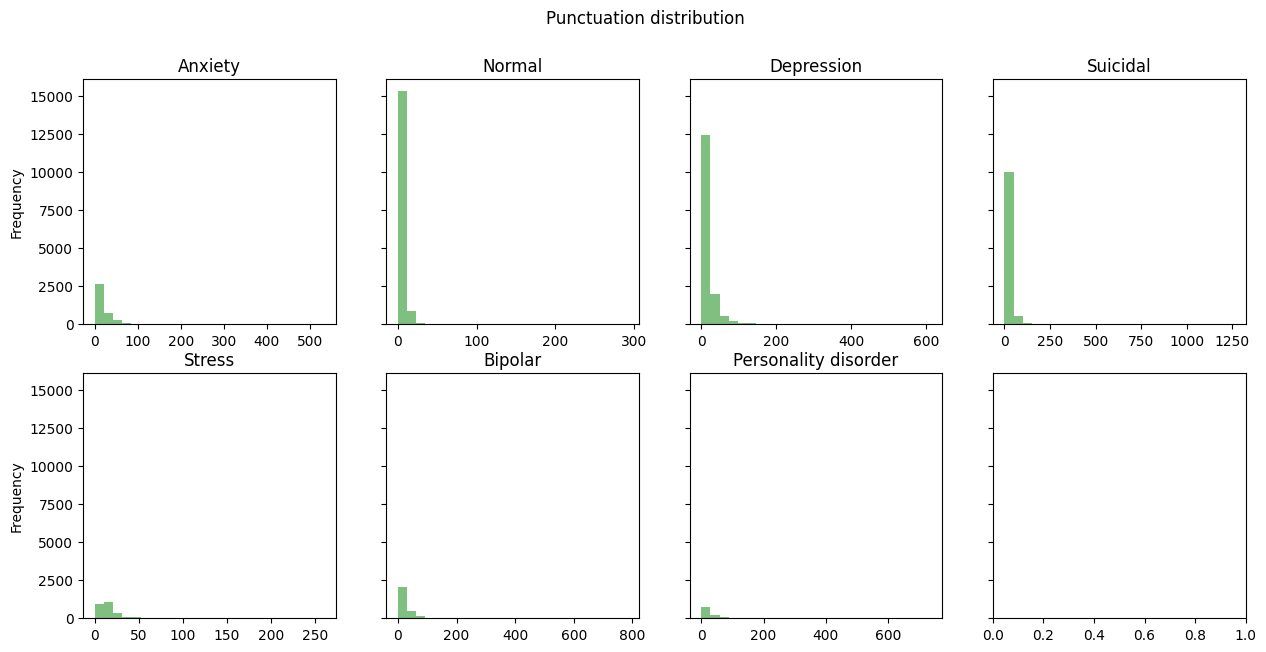

In [ ]:
class_features_distribution(data, "Punctuation distribution", lambda x: len([let for let in x if let in punctuation]))

Графики распределения цифр в классах

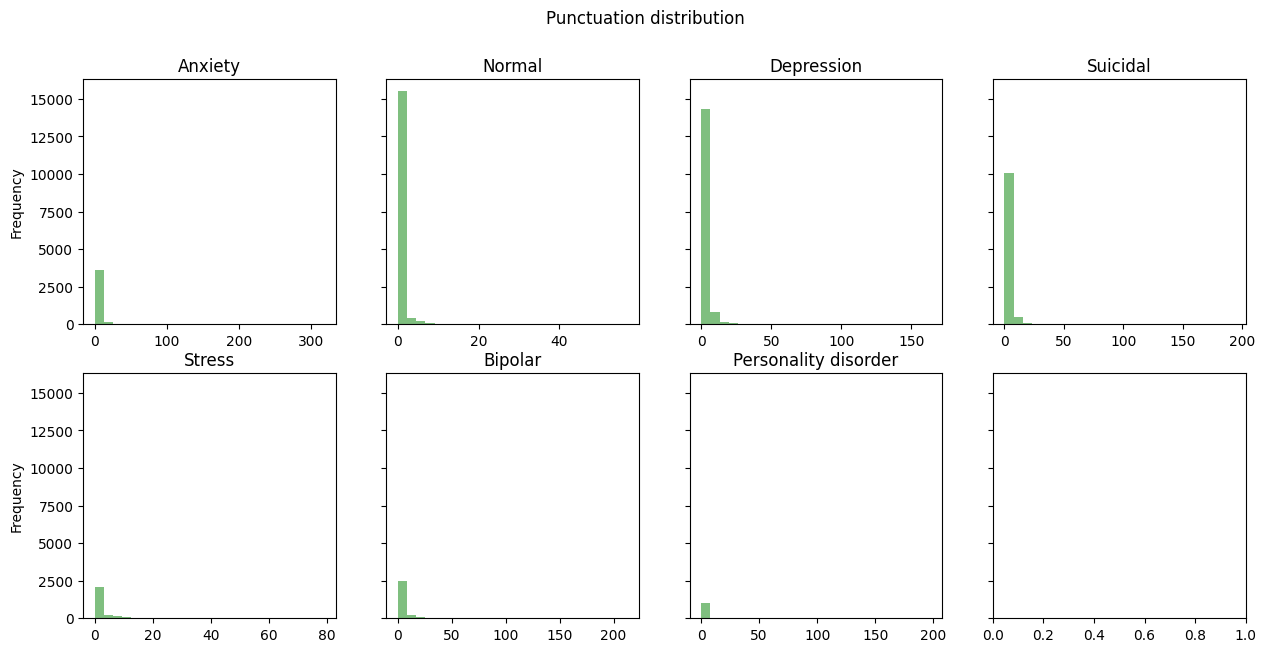

In [ ]:
class_features_distribution(data, "Punctuation distribution", lambda x: len([let for let in x if let.isdigit()]))

Графики распределения стопслов в классах

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


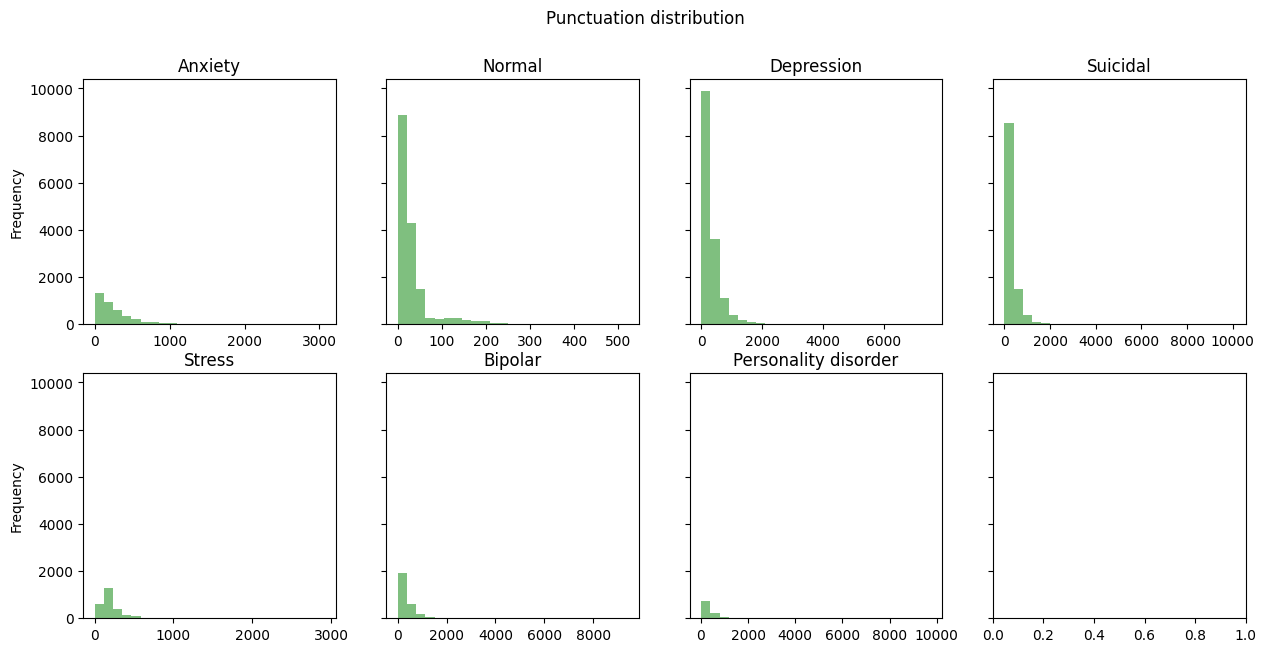

In [ ]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
class_features_distribution(data, "Punctuation distribution", lambda x: len([let for let in x if let in stop_words]))

# Preprocessing

In [ ]:
def remove_punctuation(data):
    punctuations_str = punctuation
    punctuation_re = r'[{}]'.format(punctuations_str)
    replace_punct = lambda x: re.sub(punctuation_re, '', x)
    data["statement"] = data["statement"].map(replace_punct)

    return data

In [ ]:
def remove_digits(data):
    digits_re = r'[0-9]+'
    replace_digits = lambda x: re.sub(digits_re, '', x)
    data["statement"] = data["statement"].map(replace_digits)

    return data

In [ ]:
def remove_stop_words(data):
    stop_words = set(stopwords.words('english'))
    replace_stop_words = lambda x: ' '.join([word for word in x.lower().split(' ') if word  not in stop_words])
    data["statement"] = data["statement"].map(replace_stop_words)
    return data



In [ ]:
def tokenize(data):
    data["statement"] = data["statement"].map(lambda x: x.lower().split())
    return data

In [ ]:
def stemming(data):
    stemmer = PorterStemmer()
    data["statement"] = data["statement"].map(lambda x: [stemmer.stem(item) for item in x])
    return data

In [ ]:
def lemmatization(data):
    lemmer = WordNetLemmatizer()
    data["statement"] = data["statement"].map(lambda x: [lemmer.lemmatize(item) for item in x])
    return data

In [ ]:
def vectorization(data):
    vectorizer = TfidfVectorizer()
    data["statement"] = data["statement"].map(' '.join)
    X = vectorizer.fit_transform(data["statement"])
    if "status" in data.columns:
        enc = LabelEncoder()
        enc.fit(data["status"])
        y = enc.transform(data["status"])

        return X, y
    return X


In [ ]:
data = remove_punctuation(data)
data = remove_digits(data)
data = remove_stop_words(data)
data = tokenize(data)
data = stemming(data)
data = lemmatization(data)

X, y = vectorization(data)